## ResNet50

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import seed_everything
from PIL import Image
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import pandas as pd
import seaborn as sn
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
import glob
import timm
import timm.optim
import numpy as np
from timm.scheduler import CosineLRScheduler

In [2]:
# PCBData 데이터셋 클래스를 정의합니다.
class PCBData(Dataset):
    def __init__(self, root_dir, transform=None, stage='train'):
        self.root_dir = root_dir
        self.transform = transform
        ng_files = sorted(glob.glob(os.path.join(root_dir, 'TRUE/**/*.bmp'), recursive=True))
        ok_files = sorted(glob.glob(os.path.join(root_dir, 'FALSE/**/*.bmp'), recursive=True))
        # NG와 OK 파일들에 대해 라벨 할당
        ng_files = [(file, 0) for file in ng_files]
        ok_files = [(file, 1) for file in ok_files]
        
        np.random.seed(42)
        #np.random.seed(41)
        np.random.permutation(ng_files)
        np.random.permutation(ok_files)
        
        # NG와 OK 각각을 8:1:1로 나누기 위한 인덱스 계산
        def split_indices(files):
            n = len(files)
            return int(n*0.8), int(n*0.9)

        ng_split, ok_split = split_indices(ng_files), split_indices(ok_files)
        
        # 데이터셋 나누기
        train_files = ng_files[:ng_split[0]] + ok_files[:ok_split[0]]
        val_files = ng_files[ng_split[0]:ng_split[1]] + ok_files[ok_split[0]:ok_split[1]]
        test_files = ng_files[ng_split[1]:] + ok_files[ok_split[1]:]

        if stage == 'train':
            self.files = train_files
        elif stage == 'val':
            self.files = val_files
        else:
            self.files = test_files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def image_file(self, idx):
        return self.files[idx]

# LitResnet 클래스를 정의
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.save_hyperparameters()
        # ResNet18 대신 ResNet50 사용
        #self.model = torchvision.models.resnet50(pretrained=False, num_classes=2)
        #self.lr = lr
        #self.model = timm.create_model('resnet50d', pretrained=True, num_classes=2)
        #self.model = timm.create_model('eva02_small_patch14_336', pretrained=True, num_classes=2)
        #self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2, drop_path_rate=0.1)
        #self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        #self.model.fc = torch.nn.Linear(in_features=2048, out_features=2)
        self.model = torchvision.models.efficientnet_b3(weights=torchvision.models.EfficientNet_B3_Weights.DEFAULT)
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = torch.nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("lr", self.myoptimizer.param_groups[0]['lr'], prog_bar=True)
        return loss

    def configure_optimizers(self):
        #print('lr =', self.hparams.lr)
        #optimizer = torch.optim.SGD(
        #optimizer = torch.optim.Adam(
        #    self.parameters(),
        #    lr=self.hparams.lr,
        #    #momentum=0.9,
        #    #weight_decay=5e-4,
        #)
        optimizer = timm.optim.create_optimizer_v2(
            self, opt="lookahead_AdamW", lr=self.hparams.lr, weight_decay=0.01
        )
        self.myoptimizer = optimizer
        
        #steps_per_epoch = 45000 // BATCH_SIZE
        #steps_per_epoch = 10206 // BATCH_SIZE + 1
        #steps_per_epoch = 3000 // BATCH_SIZE

        scheduler_dict = {
            #"scheduler": OneCycleLR(
            #    optimizer,
            #    0.002,
            #    epochs=self.trainer.max_epochs,
            #    steps_per_epoch=steps_per_epoch,
            #    #steps_per_epoch=1, ## LR
            #),
            "scheduler": CosineAnnealingLR(
                optimizer,
                T_max=self.trainer.max_epochs,
                eta_min=1e-6
            ),
            "interval": "epoch",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
        #return {"optimizer": optimizer}

    # Learning rate warm-up
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
        # update params
        optimizer.step(closure=optimizer_closure)
    
        # manually warm up lr without a scheduler
        warm_up_t = 3
        lr_warmup_min = 1e-5
        step = self.trainer.current_epoch
        if step < warm_up_t:
            lr_scale = min(1.0, float(step + 1) / float(warm_up_t))
            for pg in optimizer.param_groups:
                pg["lr"] = max(lr_warmup_min, lr_scale * self.hparams.lr)

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=2)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, sync_dist=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, sync_dist=True)
    
    def evaluate_debug(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=2)
        #print('loss =', loss)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, sync_dist=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, sync_dist=True)
        #print(f"{stage}_loss", loss.cpu().numpy(), f"{stage}_acc", acc.cpu().numpy())

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
        
    def validation_step(self, batch, batch_idx):
        self.evaluate_debug(batch, "val")
        
    def setup(self, stage=None):
        # 데이터 변환 정의
        '''
        transform = transforms.Compose([
            #transforms.Resize((32, 32)),
            transforms.ToTensor(),
            #pcb_normalization(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),] )
        '''
        train_transforms = torchvision.transforms.Compose(
            [
                #torchvision.transforms.Resize((336,336)),
                #torchvision.transforms.Resize((224,224)),
                #torchvision.transforms.RandomCrop(32, padding=4), #Augmentation 포함
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomVerticalFlip(),
                torchvision.transforms.RandomApply([transforms.RandomRotation(90)], p=0.5),
                torchvision.transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        val_transforms = torchvision.transforms.Compose(
            [
                #torchvision.transforms.Resize((336,336)),
                #torchvision.transforms.Resize((224,224)),
                torchvision.transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    
        # 데이터셋 로드
        self.train_dataset = PCBData(root_dir='pcb_test', transform=train_transforms, stage='train')
        self.val_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='val')
        self.test_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='test')
        
        ##self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
        #print(train_size, val_size, test_size)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)

# 설정
seed_everything(7)
#BATCH_SIZE = 256 if torch.cuda.is_available() else 64
BATCH_SIZE = 32 if torch.cuda.is_available() else 64
#BATCH_SIZE = 32 if torch.cuda.is_available() else 64

#NUM_WORKERS = int(os.cpu_count() / 2)
NUM_WORKERS = 4

model = LitResnet(lr=0.0005)

checkpoint_callback = ModelCheckpoint(monitor='val_acc', dirpath='./ckpt', mode='max', verbose=True)

# ResNet 모델에 대한 Trainer 설정
trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=4 if torch.cuda.is_available() else None,
    logger=CSVLogger(save_dir="./"),  # ResNet 모델 로그를 저장할 폴더 지정
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=1), checkpoint_callback],
    log_every_n_steps=10,
)
# 데이터셋 준비
#model.setup()
# 훈련을 시작합니다.
log_dir = trainer.logger.log_dir
trainer.fit(model)
# 테스트를 진행합니다.
#trainer.test(model)

Seed set to 7
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /home/kotech/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47.2M/47.2M [00:00<00:00, 104MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Seed set to 7
[rank: 1] Seed set to 7
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
[rank: 2] Seed set to 7
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
[rank: 3] Seed set to 7
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
-----

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 59: 'val_acc' reached 0.75215 (best 0.75215), saving model to './ckpt/epoch=0-step=59-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 1, global step 118: 'val_acc' reached 0.90773 (best 0.90773), saving model to './ckpt/epoch=1-step=118-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 2, global step 177: 'val_acc' reached 0.95815 (best 0.95815), saving model to './ckpt/epoch=2-step=177-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 3, global step 236: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 4, global step 295: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 5, global step 354: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 6, global step 413: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 7, global step 472: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 8, global step 531: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 9, global step 590: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 10, global step 649: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 11, global step 708: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 12, global step 767: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 13, global step 826: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 14, global step 885: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 15, global step 944: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 16, global step 1003: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 17, global step 1062: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 18, global step 1121: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 19, global step 1180: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


In [3]:
trainer.logger.log_dir, log_dir

('./lightning_logs/version_58', './lightning_logs/version_58')

In [4]:
ckpt_path =checkpoint_callback.best_model_path 
ckpt_path

'./ckpt/epoch=2-step=177-v1.ckpt'

,train_loss,lr-Lookahead/pg2,lr,lr-Lookahead/pg1,val_acc,val_loss
epoch,,,,,,
NaN,NaN,0.000167,NaN,0.000167,NaN,NaN
0.0,0.738609,NaN,0.000167,NaN,NaN,NaN
NaN,NaN,0.000167,NaN,0.000167,NaN,NaN
0.0,0.626925,NaN,0.000167,NaN,NaN,NaN
NaN,NaN,0.000167,NaN,0.000167,NaN,NaN


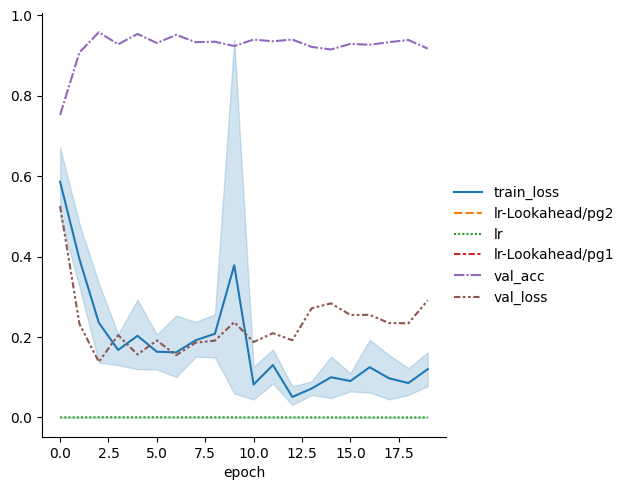

In [5]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

,train_loss,lr-Lookahead/pg2,lr,lr-Lookahead/pg1,val_acc,val_loss
epoch,,,,,,
NaN,NaN,0.000167,NaN,0.000167,NaN,NaN
0.0,0.738609,NaN,0.000167,NaN,NaN,NaN
NaN,NaN,0.000167,NaN,0.000167,NaN,NaN
0.0,0.626925,NaN,0.000167,NaN,NaN,NaN
NaN,NaN,0.000167,NaN,0.000167,NaN,NaN


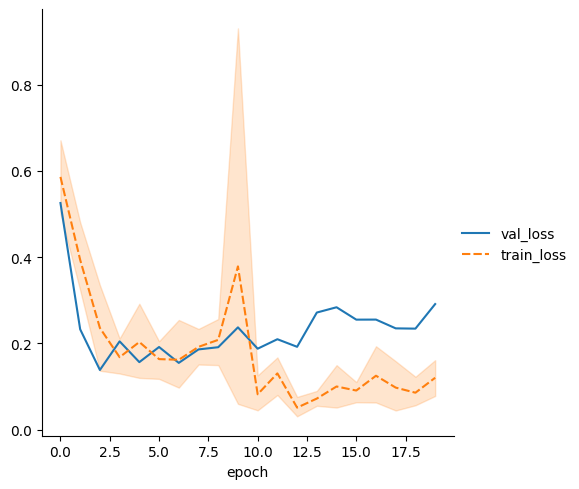

In [6]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[['val_loss', 'train_loss']], kind="line")

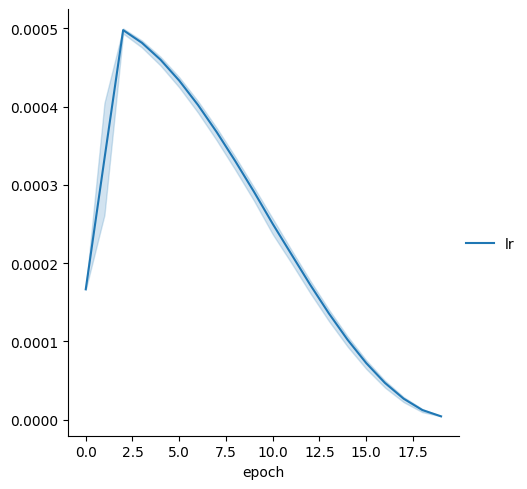

In [7]:
import pandas as pd
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
metrics = metrics[::-1]
#metrics['lr-Adam'] = metrics['lr-Adam'].fillna(method='ffill')
metrics['lr'] = metrics['lr'].fillna(method='ffill')
metrics = metrics[::-1]
#print(metrics[['lr-Adam']].head(10))
#sn.relplot(data=metrics[['lr-Adam']], kind="line") ## Learning Rate Matrix
sn.relplot(data=metrics[['lr']], kind="line") ## Learning Rate Matrix

In [8]:
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
trainer.test(model, ckpt_path=ckpt_path)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at ./ckpt/epoch=2-step=177-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at ./ckpt/epoch=2-step=177-v1.ckpt


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9763185977935791
        test_loss           0.12061160802841187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.12061160802841187, 'test_acc': 0.9763185977935791}]

In [10]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9580193758010864
        val_loss            0.13841809332370758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.13841809332370758, 'val_acc': 0.9580193758010864}]

In [15]:
def eval_dataset():

    val_transforms = torchvision.transforms.Compose(
        [
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.Resize((336,336)),
            torchvision.transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    #full_eval_dataset = PCBData(root_dir='PCB_data', transform=val_transforms)
    train_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='train')
    val_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='val')
    test_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='test')

    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)

    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)
    

    return train_dataloader, val_dataloader, test_dataloader
     


In [16]:
eval_train_dataloader, eval_val_dataloader, eval_test_dataloader = eval_dataset()

In [17]:
trainer.test(model, dataloaders=eval_train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9554569125175476
        test_loss           0.11364956945180893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11364956945180893, 'test_acc': 0.9554569125175476}]

In [18]:
trainer.test(model, dataloaders=eval_val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9558665156364441
        test_loss           0.13417093455791473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13417093455791473, 'test_acc': 0.9558665156364441}]

In [19]:
trainer.test(model, dataloaders=eval_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9817007184028625
        test_loss           0.06220428645610809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06220428645610809, 'test_acc': 0.9817007184028625}]